<a href="https://colab.research.google.com/github/rosegebhardt/Frequentist-ML/blob/master/model_assessment_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#----------INCLUDE PACKAGES

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#----------CREATE DATA

# Seed the generator
np.random.seed(420)

# Create dataframe with random values and classes
values = np.random.randn(50,5000)
ground_truth = (np.random.rand(50,1) < 0.5)
data = np.concatenate((values,ground_truth),axis=1)
df = pd.DataFrame(data)


In [ ]:
#----------SEPARATE DATA

# Separate training and testing data
indices = np.random.permutation(data.shape[0])
train_indices, test_indices = indices[:40], indices[40:]
train_data, test_data = data[train_indices,:], data[test_indices,:]

# Separate training inputs and outputs
x_train = train_data[:,0:4999]  
y_train = train_data[:,[5000]]

# Separate testing inputs and outputs
x_test = test_data[:,0:4999]
y_test = test_data[:,[5000]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  del sys.path[0]


The incorrection prediction error is 10.0%


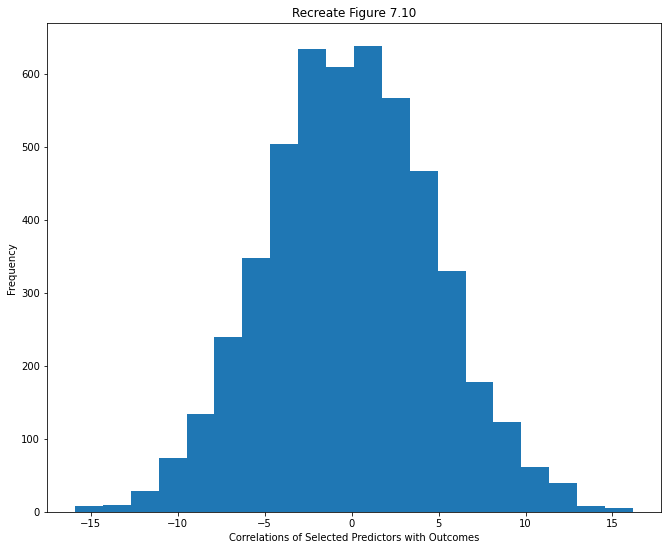

In [ ]:
#----------INCORRECT METHOD

# Step 1: Determine 100 best predictors
coefs = np.zeros([data.shape[1],1])
for index in range(data.shape[1]-1):
  coefs[index] = np.correlate(np.transpose(values[:,index]), np.transpose(ground_truth.flatten()))

# Step 2: Use 100 best predictors to build a classifier
ind = np.argsort(-coefs, axis=0)[:100]
X = np.reshape(data[:,ind],(50,100))
y = ground_truth
neigh = KNeighborsClassifier()
neigh.fit(X, y)

# Step 3: Get prediction error of the model
incorrect_predictions = neigh.predict(x_test[:,ind.flatten()])
incorrect_accuracy = 100*sum(y_test.flatten() == incorrect_predictions)/len(y_test)
incorrect_error = [100 - incorrect_accuracy]
print("The incorrection prediction error is " + str(incorrect_error).strip('[]') + "%")

# Recreate Figure 7.10
fig = plt.figure(figsize=(11,9))
plt.hist(coefs, bins = 20)
plt.title("Recreate Figure 7.10")
plt.xlabel("Correlations of Selected Predictors with Outcomes")
plt.ylabel("Frequency")
plt.show()

In [ ]:
#----------CORRECT METHOD

# Step 1: Divide the samples into K cross-validation folds at random
indices = np.random.permutation(data.shape[0])
index_array = indices.reshape([5,10])
x_train_data = np.zeros([40,5000,5])
y_train_data = np.zeros([40,1,5])
x_test_data = np.zeros([10,5000,5])
y_test_data = np.zeros([10,1,5])
for index in range(5):
  new_index_array = np.delete(index_array, index, axis=0)
  new_indices = new_index_array.reshape([1,40])
  test_indices = index_array[index,:]
  x_train_data[:,:,index] = data[new_indices.flatten(),0:5000]  
  y_train_data[:,:,index] = np.reshape(data[new_indices.flatten(),[5000]],(40,1))
  x_test_data[:,:,index] = data[test_indices.flatten(),0:5000]
  y_test_data[:,:,index] = np.reshape(data[test_indices.flatten(),[5000]],(10,1))

# Step 2: Build a classifier for each fold and get the accuracy
fold_error = np.zeros([5,1])
for index in range(5):
  # Step A: Determine 100 best predictors
  corrs = np.zeros([data.shape[1]-1,1])
  for super_index in range(data.shape[1]-1):
    corrs[super_index] = np.correlate(np.transpose(x_train_data[:,super_index,index]), np.transpose(y_train_data[:,:,index].flatten()))
  ind = np.argsort(-corrs, axis=0)[:100]
  # Step B: Use 100 best predictors to build a classifier
  X = np.reshape(x_train_data[:,ind,index],(40,100))
  y = y_train_data[:,:,index].flatten()
  neigh = KNeighborsClassifier()
  neigh.fit(X, y)
  # Step C: Get prediction error of the model
  # print(x_test_data[:,ind,index].reshape(10,100).shape)
  fold_predictions = neigh.predict(x_test_data[:,ind,index].reshape(10,100))
  fold_accuracy = 100*sum(y_test_data[:,:,index].flatten() == fold_predictions)/len(y_test_data)
  fold_error[index] = [100 - fold_accuracy]
  #print("The true prediction error is " + str(fold_error).strip('[]') + "%")
true_error = sum(fold_error)/5
print("The true prediction error is " + str(true_error).strip('[]') + "%")

The true prediction error is 44.%
